# **TP2 - CRÍTICAS CINEMATOGRÁFICAS - Blue Squad - Notebook Ensambles**

Integrantes:
- Franco Ricciardo Calderaro
- Matias Agustin Ferrero Cipolla
- Carlos Orqueda
- Sebastian Kraglievich


## Imports

In [ ]:
# No queremos ver la salida de pip
%%capture

%pip install langid
!pip install scikit-learn==1.2.2
!pip install keras
!pip uninstall tensorflow -y
!pip install tensorflow
!pip install scikeras

In [ ]:
# Manipulacion y Visualizacion de datos
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
from collections import Counter

#Libreria Procesamiento de Lenguaje Natural
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import scipy.stats as st
import langid

#Bag of Words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Ensambles
from sklearn.ensemble import VotingClassifier, StackingClassifier

#Red Neuronal
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
#from keras.wrappers.scikit_learn import KerasClassifier   #o Sci-Keras!!!

#Modelos y Métricas
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, precision_recall_curve, roc_auc_score, recall_score, accuracy_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
import joblib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [ ]:
criticas = pd.read_csv('./train.csv')
kaggle_test = pd.read_csv('./test.csv')

## Preprocesamiento

Arrancamos analizando el dataframe para identificar posibles datos faltantes.

In [ ]:
criticas.isna().sum()

ID             0
review_es      0
sentimiento    0
dtype: int64

Analizando la columna *sentimiento*, observamos que la variable toma dos valores: positivo y negativo.

Ademas podemos ver que se ambos valores son el 50% de la variable.

In [ ]:
criticas['sentimiento'].value_counts()

sentimiento
positivo    25000
negativo    25000
Name: count, dtype: int64

Para poder entrenar los modelos, modificamos la variable *sentimiento* para que tenga valores {Negativo = 0, Positivo = 1 }.

In [ ]:
criticas.replace(to_replace = {'negativo' : 0, 'positivo' : 1}, inplace = True)

Para asegurar que solo tengamos criticas en español, creamos una funcion que detecte el idioma en el que estan escritas y se la aplicamos a todas las filas del dataframe.

In [ ]:
def detect_language(text):
    return langid.classify(text)[0]

In [ ]:
criticas['language'] = criticas['review_es'].apply(detect_language)
criticas_spanish = criticas[criticas['language'] == 'es']
criticas_spanish.shape

(48179, 4)

Obtenemos una diferencia de 1821 criticas que son de otros idiomas, y eliminamos para quedarnos solo con las reseñas en español.

In [ ]:
criticas_spanish = criticas_spanish.drop(columns=['language'])
criticas = criticas_spanish.copy()

A continuacion, creamos una lista de la frecuencia de cada palabra en nuestro dataframe. Gracias a esto podemos identificar las palabras mas comunes y decidir cuales podemos filtrar para reducir la cantidad de variables en nuestro analisis.

Despuas de calcular la frecuencia de las palabras, evaluamos cuales pueden ser eliminadas. Las palabras mas frecuentes podrian ser consideradas como stopwords, mientras que las poco frecuentes podrian ser terminos irrelevantes.

Este proceso simplifica nuestro dataframe, y nos permite centrarnos en las palabras mas relevantes, facilitando la interpretacion de los resultados finales.

In [ ]:
# Combine all reviews into a single string
all_reviews = ' '.join(criticas['review_es'])
all_reviews = all_reviews.lower()

# Split the combined text into words using spaces, commas, and periods as delimiters
words = re.split(r'[\s,.()!?¿¡0123456789#$:;+*%&/={}"]', all_reviews)

# Remove empty strings resulting from splitting
words = [word for word in words if word]

# Count the frequency of each word using Counter
word_counts = Counter(words)

# Convert word_counts to a DataFrame
word_counts_df = pd.DataFrame(list(word_counts.items()), columns=['palabra', 'frecuencia'])
word_counts_df = word_counts_df.sort_values(by='frecuencia', ascending=False)

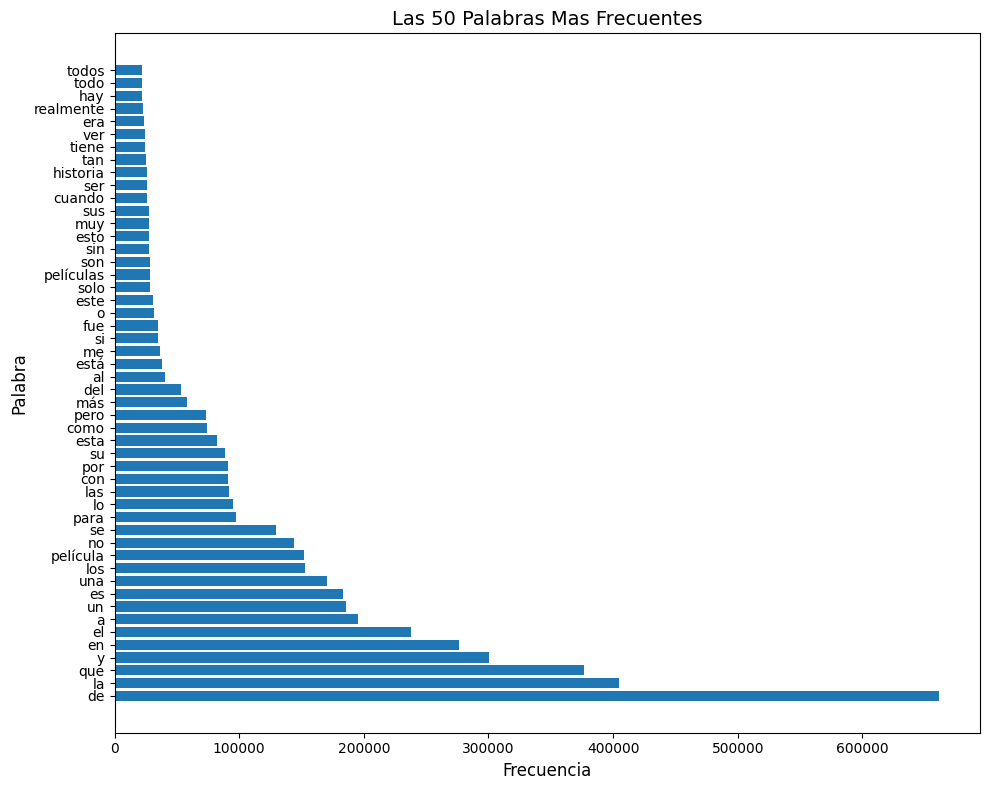

In [ ]:
plt.figure(figsize = (10, 8))
plt.barh(word_counts_df['palabra'][:50], word_counts_df['frecuencia'][:50])

plt.ylabel('Palabra', fontsize = 12)
plt.xlabel('Frecuencia', fontsize = 12)
plt.title('Las 50 Palabras Mas Frecuentes', fontsize = 14)
plt.yticks(fontsize = 10)

plt.tight_layout()
plt.show()

Observamos una marcada presencia de palabras repetidas, principalmente palabras funcionales (articulos, conjunciones, preposiciones), mientras que las palabras que no son consideradas palabras funcionales muestran una frecuencia más uniforme. Para mejorar el análisis, eliminamos las palabras funcionales identificadas hasta ahora, ya que no aportan informacion relevante.

También eliminamos numerosas palabras con una frecuencia igual a 1 que suelen ser inexistentes o no están relacionadas con el análisis de sentimientos, por lo que, tambien decidimos descartarlas del analisis.

### NLTK

Con NLTK (Natural Language Toolkit), preparamos nuestro dataset con procesos de preprocesamiento, simplificando nuestras variables para un análisis más efectivo. Para esto, realizamos:

*   __Tokenización__
*   __Eliminación de stopwords:__
*   __Lemmatization:__

In [ ]:
lemmatizer = WordNetLemmatizer()  # No hay lematizador específico en NLTK para español, pero usaremos uno general
stop_words = set(stopwords.words('spanish'))

def preprocesar_texto_lemm_regex(texto):

    # Reemplazar signos de puntuación por un espacio
    texto = re.sub(r'[^\w\s]', ' ', texto)

    # Eliminar cualquier secuencia de más de un espacio
    texto = re.sub(r'\s+', ' ', texto).strip()

    # Tokenizacion
    tokens = word_tokenize(texto.lower())

    # quitar stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lematización
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    return ' '.join(tokens_lemmatized)

Tambien, hemos probado utilizar varios Regex, como por ejemplo, para eliminar caracteres especiales, diacriticos, signos de puntuacion, convertir todas las palabras a minisculas, etc. Sin embargo, los mejores resultados en Kaggle se siguen alcanzando con el `preprocesar_texto_lemm_regex` (con lemmatize de NTLK y 2 regex simples). Cuanto mas simple sea el análisis; mejor!

In [ ]:
criticas_filtradas = criticas.copy()
criticas_filtradas['processed_review'] = criticas_filtradas['review_es'].apply(preprocesar_texto_lemm_regex)

Como tenemos datos categóricos y nuestros modelos necesitan datos numéricos, vamos a utilizar un modelo para convertir palabras a vectores de números.

Y para poder mejorar el rendimiento en la competencia de kaggle, utilizamos el vocabulario del archivo de test.

Vamos a calcular las matrices de ocurrencias de términos usando sklearn.

Ambas clases primero construyen el vocabulario total, y luego:
- **TF-IDF**: calcula la frecuencia de cada termino por documento, y normaliza por el total de documentos donde el termino aparece.

Por ultimo, generamos los conjuntos de train y test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(criticas_filtradas.processed_review,
                                                    criticas_filtradas.sentimiento,
                                                    test_size = 0.3,
                                                    random_state = 2,
                                                    shuffle = True,
                                                    stratify = criticas_filtradas['sentimiento'].values)

## Ensamble

El ensamble que elegimos es Voting, por lo tanto, este modelo decide con los votos individuales de cada sub-modelo. Los parametros importantes son:

*   Estimators: Todos los clasificadores a utilizar
*   Voting: La estrategia de voto:

      1) Hard: Elige el valor dado por mayoría estricta.
      
      2) Soft: Pondera con cálculos como el promedio, etc.



Primero importamos los clasificadores, recordemos que son Pipelines!

In [ ]:
rf_clf = joblib.load('mejor_rf.joblib')
bayes_clf = joblib.load('mejor_bn.joblib')
xgb_clf = joblib.load('mejor_xgb.joblib')
modelo_red = joblib.load('mejor_red.joblib')

A excepcion de la red que no es Pipeline, y por ende la creamos.

In [ ]:
red_neuronal = KerasClassifier(model = modelo_red, epochs = 100, batch_size = 50, verbose = 0)
vectorizer_red = joblib.load('vectorizer_con_vocabulario_test_mejor_red.joblib')

red_clf = Pipeline([('tfidf_red', vectorizer_red), ('modelo_red_clf', red_neuronal)])

Creamos el ensamble y realizamos la prediccion.

In [ ]:
vot_clf = VotingClassifier(estimators = [('bn', bayes_clf), ('rf', rf_clf),
                                         ('xgb', xgb_clf), ('red', red_clf)],
                           voting = 'soft', n_jobs = -1)

modelo = vot_clf.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

resultados = pd.DataFrame(zip(y_test, y_pred), columns = ['test' , 'pred'])
resultados.sample(10)

,test,pred
10583,1,1
12828,0,0
5528,1,1
553,1,1
387,1,1
13569,1,1
14329,0,0
2065,0,0
5865,1,0
12960,1,1


Graficamos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *sentimiento* son:

*   0 = Negativo
*   1 = Positivo

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      7239
           1       0.87      0.89      0.88      7215

    accuracy                           0.88     14454
   macro avg       0.88      0.88      0.88     14454
weighted avg       0.88      0.88      0.88     14454



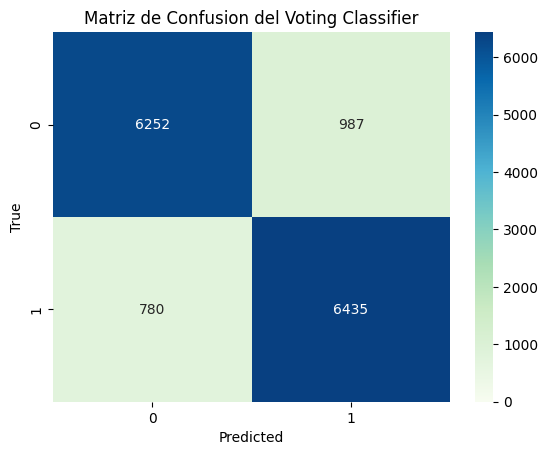

In [ ]:
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusion del Voting Classifier')

print(classification_report(y_test, y_pred))
plt.show()

Para respaldar el grafico calculamos las metricas en el conjunto de evaluacion.


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8777501037775011
Recall: 0.8918918918918919
Precision: 0.8670169765561844
f1 score: 0.8792785406845666


## Kaggle Test

Ahora buscamos las predicciones del modelo con los datos del test de kaggle.

In [ ]:
y_pred_kaggle = modelo.predict(kaggle_test['review_es'])

Exportamos el CSV de las predicciones obtenidas para subirlo a Kaggle.

In [ ]:
submit = pd.DataFrame(zip(kaggle_test['ID'], y_pred_kaggle), columns = ['ID' , 'sentimiento'])
submit['sentimiento'].replace(to_replace = {0 : 'negativo', 1 : 'positivo'}, inplace = True)

Y realizamos un grafico para visualizar las predicciones del modelo. Podemos observar que modelo predice mayoria de positivos.

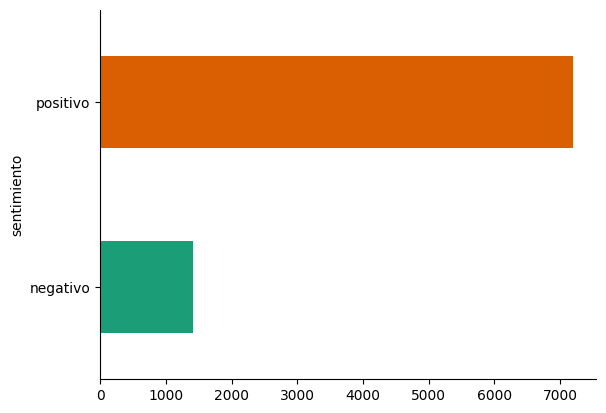

In [ ]:
submit.groupby('sentimiento').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
ruta_archivo = '/content/VOTE-05.csv'
submit.to_csv(ruta_archivo, index=False)

Para terminar con el modelo, lo guardamos en un archivo Joblib.

In [ ]:
joblib.dump(modelo, 'voting.joblib')

['random_forest.joblib']